# Productivity Classification NotebookThis notebook loads data and prepares a productivity classification workflow.

In [210]:
# reading data on google drive
from google.colab import drive
# Mount your Google Drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

# Load CSV file from Google Drive
file_path = '/content/drive/MyDrive/other/data/Data for MSC Thesis/eth_householdgeovariables_y5.csv'
df = pd.read_csv(file_path)

print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
        household_id  dist_road  dist_market  dist_border  dist_popcenter  \
0  20101010100104011        7.7   162.300003    82.900002             0.4   
1  20101010100104022        7.7   162.300003    82.900002             0.4   
2  20101010100104033        7.7   162.300003    82.900002             0.4   
3  20101010100104044        7.7   162.300003    82.900002             0.4   
4  20101010100104055        7.7   162.300003    82.900002             0.4   

   dist_admhq  af_bio_1_x  af_bio_8_x  af_bio_12_x  af_bio_13_x  ...  \
0         0.0         283         307          184           47  ...   
1         0.0         283         307          184           47  ...   
2         0.0         283         307          184           47  ...   
3         0.0         283         307          184           47  ...   
4         0.0         283         307          1

In [211]:
#----------------------------------------
#1 Drop columns with more than 40% missing
#----------------------------------------
missing_threshold = 0.4
cols_to_drop = df.columns[df.isnull().mean() > missing_threshold]

print("Dropping columns:", cols_to_drop.tolist())
df = df.drop(columns=cols_to_drop)

# 2. Remove spatial leakage
#df = df.drop(columns=['lat_dd_mod', 'lon_dd_mod'], errors='ignore')

# 3. Winsorize numeric features
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    if col not in ['household_id']:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower, upper)

Dropping columns: ['c2_eviarea_avg', 'c2_evimax_avg', 'c2_grn_avg', 'c2_sen_avg', 'c2_h2021_eviarea', 'c2_h2021_evimax', 'c2_h2021_grn', 'c2_h2021_sen']


In [212]:
# check number of distinic catagory
for col in ['ssa_aez09', 'landcov']:
    print(f"\nColumn: {col}")
    print("Number of distinct categories:", df[col].nunique())
    print("Categories:", df[col].unique())


Column: ssa_aez09
Number of distinct categories: 7
Categories: ['Tropic-warm/semiarid' 'Tropic-warm/arid' 'Tropic-cool/subhumid'
 'Tropic-cool/semiarid' 'Tropic-cool/humid' 'Tropic-cool/arid'
 'Tropic-warm/subhumid']

Column: landcov
Number of distinct categories: 9
Categories: ['Bare/sparse vegetation' 'Cropland' 'Built-up' 'Shrubs'
 'Herbaceous vegetation' 'Open forest unknown'
 'Closed forest deciduous broad leaf' 'Closed forest evergreen broad leaf'
 'Open forest deciduous broad leaf']


In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890 entries, 0 to 4889
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   household_id       4890 non-null   int64  
 1   dist_road          4890 non-null   float64
 2   dist_market        4890 non-null   float64
 3   dist_border        4890 non-null   float64
 4   dist_popcenter     4890 non-null   float64
 5   dist_admhq         4890 non-null   float64
 6   af_bio_1_x         4890 non-null   int64  
 7   af_bio_8_x         4890 non-null   int64  
 8   af_bio_12_x        4890 non-null   int64  
 9   af_bio_13_x        4890 non-null   int64  
 10  af_bio_16_x        4890 non-null   int64  
 11  afmnslp_pct        4890 non-null   int64  
 12  srtm_1k            4890 non-null   int64  
 13  popdensity         4890 non-null   int64  
 14  cropshare          4890 non-null   int64  
 15  sq1                4890 non-null   int64  
 16  sq2                4890 

In [214]:
# ==============================
# 2. Check columns 'ssa_aez09',
# ==============================
print("Before Encoding:")
print(df[['ssa_aez09','landcov']].head())

# ==============================
# 4. One-Hot Encode categorical columns
# ==============================
df_encoded = pd.get_dummies(
    df,
    columns=['landcov'],
    drop_first=True   # avoids multicollinearity (important for regression)
)

# ==============================
# 5. View results
# ==============================
print("\nAfter Encoding:")
print(df_encoded.head())

print("\nNew columns created:")
new_cols = [col for col in df_encoded.columns if 'ssa_aez09_' in col or 'landcov_' in col]
print(new_cols)

# ==============================
# 6. Check dataset shape
# ==============================
print("\nOriginal shape:", df.shape)
print("Encoded shape:", df_encoded.shape)

# change to boolean to numerical value
#bool_cols = df_encoded.select_dtypes(include='bool').columns
#df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)
df=df_encoded.copy()

Before Encoding:
              ssa_aez09                 landcov
0  Tropic-warm/semiarid  Bare/sparse vegetation
1  Tropic-warm/semiarid  Bare/sparse vegetation
2  Tropic-warm/semiarid  Bare/sparse vegetation
3  Tropic-warm/semiarid  Bare/sparse vegetation
4  Tropic-warm/semiarid  Bare/sparse vegetation

After Encoding:
        household_id  dist_road  dist_market  dist_border  dist_popcenter  \
0  20101010100104011        7.7   162.300003    82.900002             0.5   
1  20101010100104022        7.7   162.300003    82.900002             0.5   
2  20101010100104033        7.7   162.300003    82.900002             0.5   
3  20101010100104044        7.7   162.300003    82.900002             0.5   
4  20101010100104055        7.7   162.300003    82.900002             0.5   

   dist_admhq  af_bio_1_x  af_bio_8_x  af_bio_12_x  af_bio_13_x  ...  \
0         0.0         283         307          184           47  ...   
1         0.0         283         307          184           47  ...   

In [215]:
# ------------------------------
# FULL PREPROCESSING PIPELINE WITH SMOTE (NO WARNINGS)
# ------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# ------------------------------
# Step 1: Drop irrelevant/correlated columns
# ------------------------------

cols_to_drop = [
    'h2021_eviarea','h2021_sen','h2021_tot','h2021_wetQ','h2021_grn','sen_avg','anntot_avg',# OR 'anntot_avg''af_bio_12_x
     'h2021_evimax','eviarea_avg','af_bio_16_x','twi_ne','grn_avg','wetQ_avgstart',
    'h2021_tot','suppress','af_bio_13_x','wetQ_avg','h2021_wetQstart',
'af_bio_8_x','wetQ_avgstart',' h2021_wetQ','pct_urban_center',
]
df = df.drop(columns=cols_to_drop, errors='ignore')

df['sq1_sq2_mean'] = df[['sq1','sq2']].mean(axis=1)
df = df.drop(columns=['sq1','sq2'])
df['sq1_sq2_mean'] = df[['sq5','sq6']].mean(axis=1)
df = df.drop(columns=['sq5','sq6'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890 entries, 0 to 4889
Data columns (total 29 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   household_id                                4890 non-null   int64  
 1   dist_road                                   4890 non-null   float64
 2   dist_market                                 4890 non-null   float64
 3   dist_border                                 4890 non-null   float64
 4   dist_popcenter                              4890 non-null   float64
 5   dist_admhq                                  4890 non-null   float64
 6   af_bio_1_x                                  4890 non-null   int64  
 7   af_bio_12_x                                 4890 non-null   int64  
 8   afmnslp_pct                                 4890 non-null   int64  
 9   srtm_1k                                     4890 non-null   int64  
 10  popdensity  

In [216]:
# Convert all boolean columns to integers (0/1)
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

# Quick check
print(df[bool_cols].head())
print(df.dtypes)

   landcov_Built-up  landcov_Closed forest deciduous broad leaf  \
0                 0                                           0   
1                 0                                           0   
2                 0                                           0   
3                 0                                           0   
4                 0                                           0   

   landcov_Closed forest evergreen broad leaf  landcov_Cropland  \
0                                           0                 0   
1                                           0                 0   
2                                           0                 0   
3                                           0                 0   
4                                           0                 0   

   landcov_Herbaceous vegetation  landcov_Open forest deciduous broad leaf  \
0                              0                                         0   
1                              0      

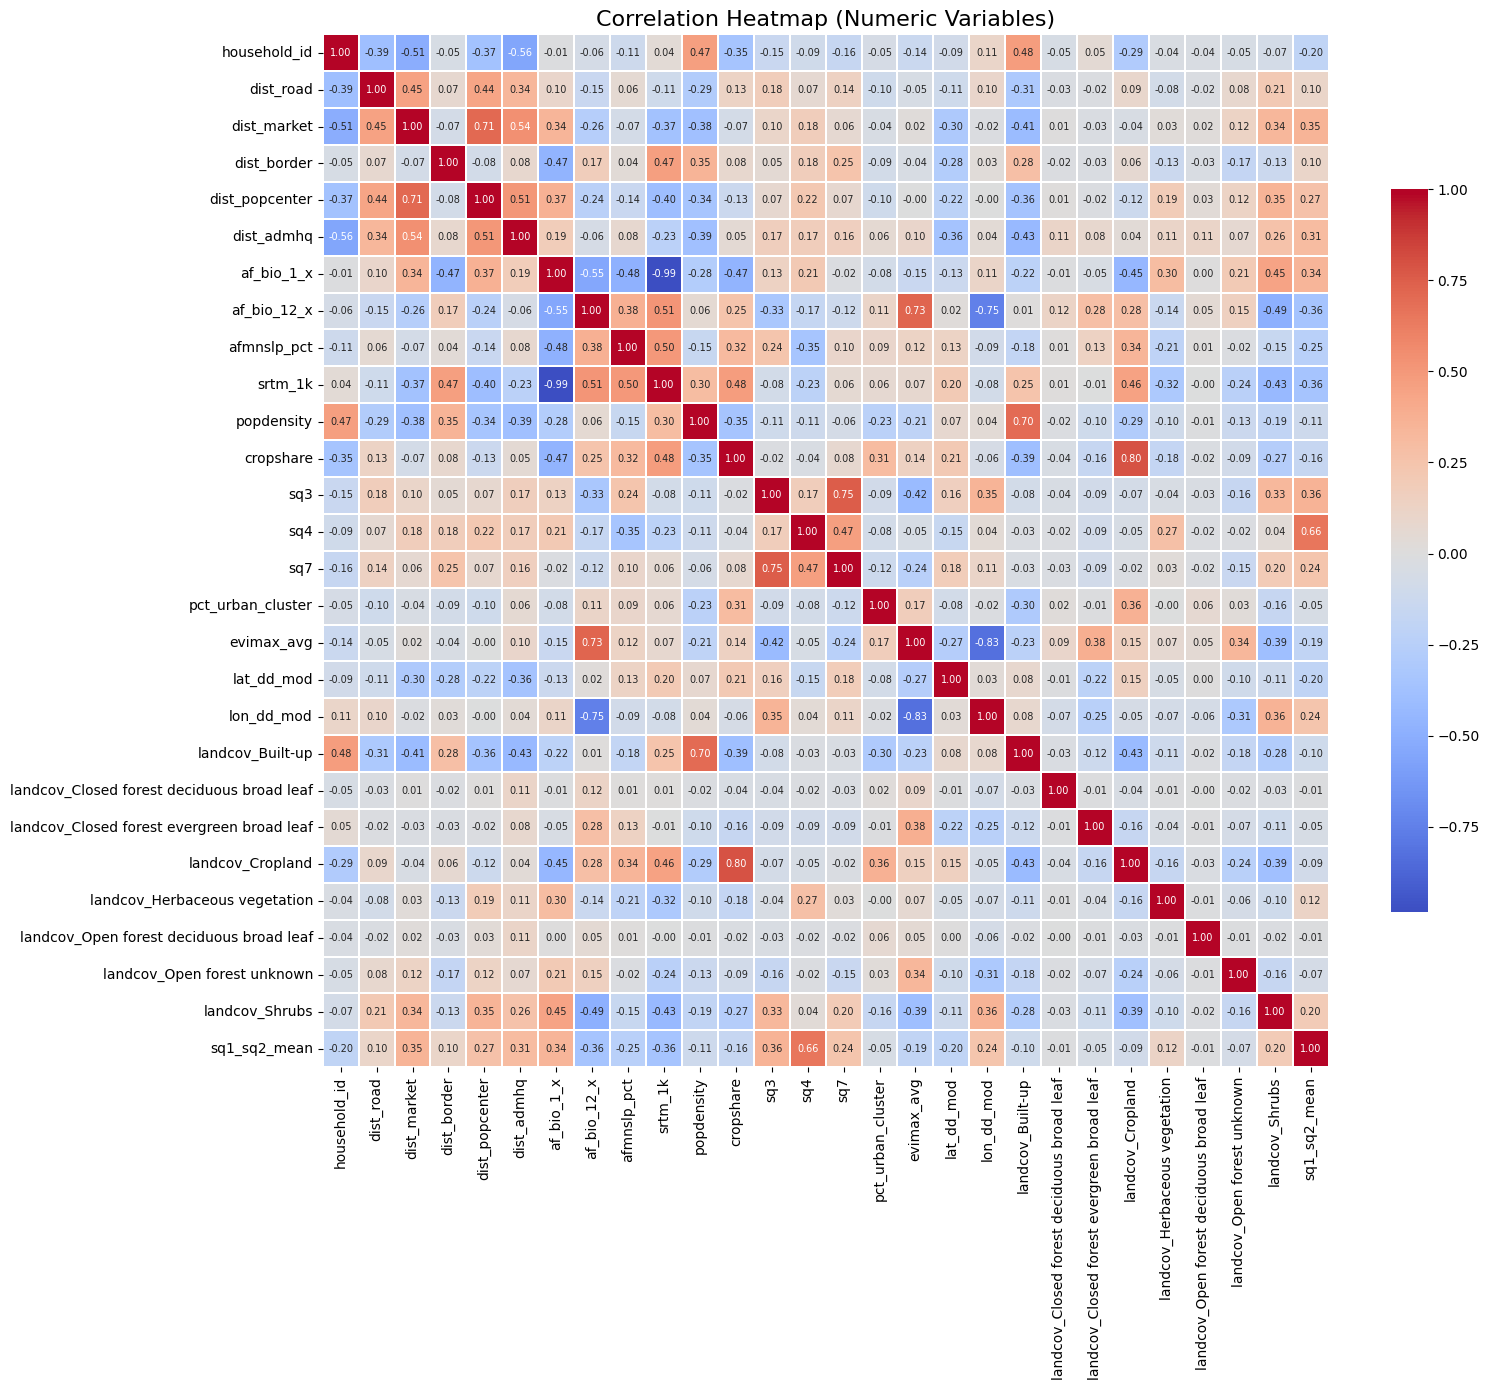

In [217]:
# ==========================================================
# CORRELATION HEATMAP WITH NUMBERS (FIXED)
# ==========================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# select numeric columns
num_df = df.select_dtypes(include=['int64','float64'])

# compute correlation matrix
corr_matrix = num_df.corr()

# plot heatmap with values
plt.figure(figsize=(16,14))

sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    annot=True,          # ✅ show numbers
    fmt=".2f",           # ✅ format numbers
    annot_kws={"size":7},# ✅ smaller font to fit
    linewidths=0.3,
    square=False,
    cbar_kws={"shrink": .7}
)

plt.title("Correlation Heatmap (Numeric Variables)", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [218]:
# =============================================================================
# ZONE-AWARE PRODUCTIVITY DSS (Clustering + 3-CLASS PRODUCTIVITY + MAP)
# =============================================================================

import pandas as pd
import numpy as np
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster, HeatMap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from lightgbm import LGBMClassifier
import warnings
import random

warnings.filterwarnings('ignore')

# ===========================
# 0. FIX RANDOM SEEDS
# ===========================
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# ===========================
# 1. PREPROCESSING
# ===========================
# Fill missing numeric values with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Encode AEZ zones
le = LabelEncoder()
df['aez_encoded'] = le.fit_transform(df['ssa_aez09'])

# Sort by household_id to make clustering & mapping reproducible
df = df.sort_values('household_id').reset_index(drop=True)

# ===========================
# 2. ECOLOGICAL CLUSTERING (KMeans)
# ===========================
cluster_cols = ['af_bio_1_x', 'af_bio_12_x', 'srtm_1k']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[cluster_cols].fillna(0))

kmeans = KMeans(n_clusters=7, random_state=RANDOM_STATE, n_init=10)
df['zone_cluster'] = kmeans.fit_predict(X_scaled)

# Silhouette score
sil_score = silhouette_score(X_scaled, df['zone_cluster'])
print("Silhouette Score (clustering):", round(sil_score, 4))

# ===========================
# 3. CREATE 3-CLASS PRODUCTIVITY TARGET
# ===========================
df['evimax_class'] = pd.qcut(df['evimax_avg'], q=3, labels=['Low', 'Medium', 'High'])
print("Target distribution:\n", df['evimax_class'].value_counts())

# ===========================
# 4. FEATURES AND TARGET
# ===========================
exclude = ['evimax_avg','evimax_class','lat_dd_mod','lon_dd_mod','household_id','zone_cluster','ssa_aez09']
X = df.drop(columns=exclude, errors='ignore')
y = df['evimax_class']

# ===========================
# 5. TRAIN-TEST SPLIT
# ===========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# ===========================
# 6. PIPELINE + GRIDSEARCHCV
# ===========================
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LGBMClassifier(random_state=RANDOM_STATE, verbose=-1, deterministic=True))
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__num_leaves': [15, 31]
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("\nBest Parameters:", grid.best_params_)
print("Best CV Accuracy:", round(grid.best_score_,4))

# ===========================
# 7. TEST SET PERFORMANCE
# ===========================
y_pred = grid.predict(X_test)

print("\nTest Accuracy:", round(accuracy_score(y_test, y_pred),4))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low','Medium','High']))

# ===========================
# 8. PREPARE TEST RESULTS FOR MAPPING
# ===========================
test_results = X_test.copy()
test_results['true_class'] = y_test
test_results['pred_class'] = y_pred
test_results['zone_cluster'] = df.loc[X_test.index,'zone_cluster']
test_results['zone_name'] = df.loc[X_test.index,'ssa_aez09']
test_results['lat'] = df.loc[X_test.index,'lat_dd_mod']
test_results['lon'] = df.loc[X_test.index,'lon_dd_mod']
test_results = test_results.dropna(subset=['lat','lon'])

gdf = gpd.GeoDataFrame(
    test_results,
    geometry=gpd.points_from_xy(test_results.lon, test_results.lat),
    crs="EPSG:4326"
)

# ===========================
# 9. CREATE INTERACTIVE MAP
# ===========================
m = folium.Map(location=[gdf.lat.mean(), gdf.lon.mean()], zoom_start=6, tiles='cartodbpositron')

# Marker cluster
marker_layer = MarkerCluster(name="Households").add_to(m)
color_map = {'Low':'red','Medium':'orange','High':'green'}

for _, row in gdf.iterrows():
    folium.Marker(
        [row.lat,row.lon],
        popup=f"""
        <b>AEZ Zone:</b> {row.zone_name}<br>
        <b>Cluster:</b> {row.zone_cluster}<br>
        <b>Prediction:</b> {row.pred_class}<br>
        <b>Actual:</b> {row.true_class}
        """,
        icon=folium.Icon(color=color_map[row.pred_class])
    ).add_to(marker_layer)

# Heatmap for low productivity
low_points = gdf[gdf.pred_class=='Low'][['lat','lon']].values.tolist()
if low_points:
    HeatMap(low_points, radius=12, name="Low Productivity Risk").add_to(m)

# AEZ toggle layer
zone_layer = folium.FeatureGroup(name="Show AEZ Zones")
for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row.lat,row.lon],
        radius=2,
        fill=True,
        fill_opacity=0.4,
        popup=row.zone_name
    ).add_to(zone_layer)
zone_layer.add_to(m)

# Legend
legend_html = """
<div style="
position: fixed;
bottom: 40px;
left: 40px;
width: 250px;
height: 300px;
background-color: white;
border:2px solid grey;
z-index:9999;
font-size:14px;
padding: 10px;
">
<b>Productivity Classes</b><br>
<i style="color:red">●</i> Low<br>
<i style="color:orange">●</i> Medium<br>
<i style="color:green">●</i> High<br><br>
<b>Tropical AEZ Zones</b><br>
Tropic-warm/semiarid<br>
Tropic-warm/arid<br>
Tropic-cool/subhumid<br>
Tropic-cool/semiarid<br>
Tropic-cool/humid<br>
Tropic-cool/arid<br>
Tropic-warm/subhumid
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))
folium.LayerControl().add_to(m)

# Save map if needed
# m.save("zone_aware_productivity_map.html")

m

Silhouette Score (clustering): 0.4919
Target distribution:
 evimax_class
Low       1977
High      1604
Medium    1309
Name: count, dtype: int64
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best Parameters: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 200, 'classifier__num_leaves': 15}
Best CV Accuracy: 0.9985

Test Accuracy: 0.9969

Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00       321
      Medium       1.00      0.99      1.00       395
        High       0.99      1.00      0.99       262

    accuracy                           1.00       978
   macro avg       1.00      1.00      1.00       978
weighted avg       1.00      1.00      1.00       978




Top 15 Feature Importances (gain):
af_bio_12_x          1541
dist_border          1104
dist_market           938
srtm_1k               646
cropshare             610
af_bio_1_x            487
dist_road             406
pct_urban_cluster     404
dist_popcenter        387
popdensity            385
afmnslp_pct           369
dist_admhq            360
aez_encoded           235
sq3                   227
sq7                    62
dtype: int32


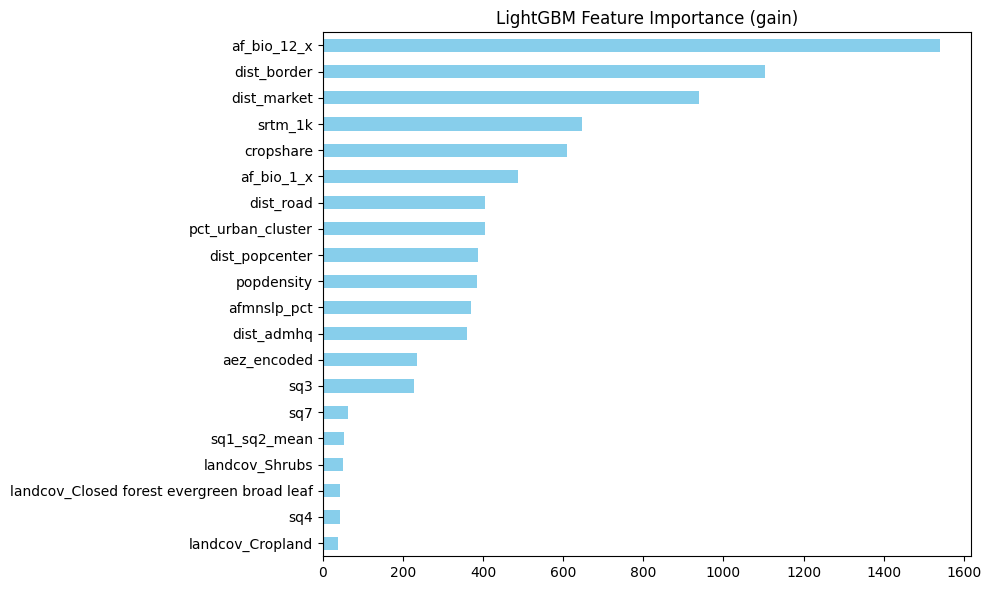

In [219]:
# Get the trained classifier from the fitted GridSearchCV
# The best performing, fitted pipeline is found in `grid.best_estimator_`
# We then access the 'classifier' step within that best pipeline.
clf = grid.best_estimator_.named_steps['classifier']

# Importance (use 'gain' or 'split')
importances = pd.Series(
    clf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print("\nTop 15 Feature Importances (gain):")
print(importances.head(15))

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
importances.head(20).plot(kind='barh', color='skyblue')
plt.title("LightGBM Feature Importance (gain)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

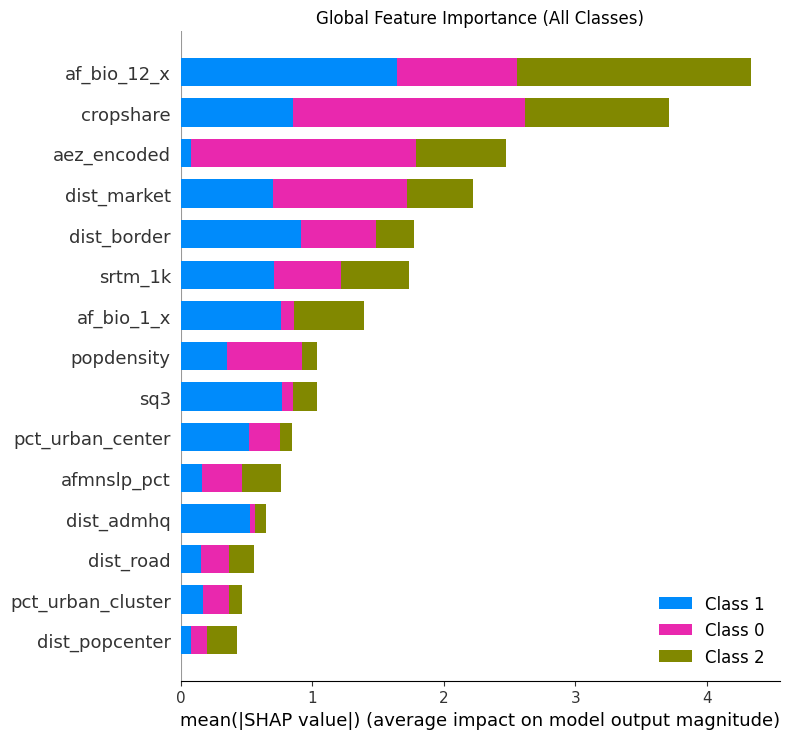

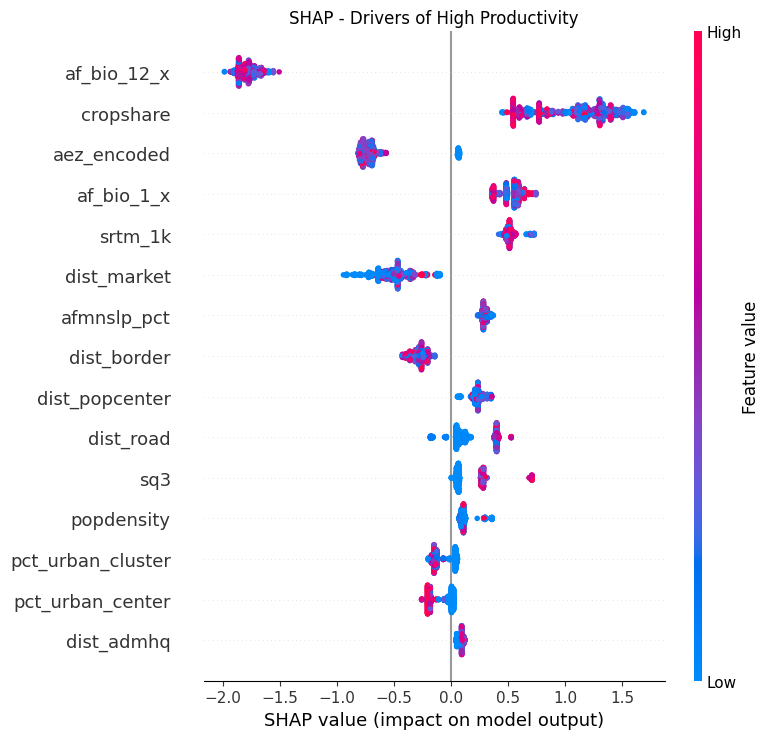

In [184]:
import shap
import matplotlib.pyplot as plt

# Fix: Use the correct step name 'classifier' from the best fitted estimator
clf = grid.best_estimator_.named_steps['classifier']
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# Bar plot - overall importance across classes
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15, show=False)
plt.title("Global Feature Importance (All Classes)")
plt.tight_layout()
plt.show()

# Beeswarm for High productivity (class 2)
shap.summary_plot(
    shap_values[:, :, 2],
    X_test,
    max_display=15,
    show=False
)
plt.title("SHAP - Drivers of High Productivity")
plt.tight_layout()
plt.show()